In [5]:
import pandas as pd
import numpy as np
import math as m

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize 
from scipy import interpolate
from scipy  import stats

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression

import xlrd 
import os
import tqdm
import inspect

import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [39]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 21 16:28:42 2021
@author: Improve by JULIO FERNÁNDEZ
"""

'\nCreated on Sat Apr 21 16:28:42 2021\n@author: Improve by JULIO FERNÁNDEZ\n'

In [4]:
# KPSS & ADF test
def kpss_test(series, **kw): 
    print ('Results of Kwiatkowski-Phillips-Schmidt-Shin Test:')   
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    kys, vls =[], []
    for key, value in critical_values.items():
        kys.append(key), vls.append(value)
    print('Critial Values (CV) :')
    df = pd.DataFrame({'(%ST at)':kys, 'CV':vls})
    print(df)
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

def adf_test(series):
    print ('Results of Augmented Dickey-Fuller Test:')
    statistic, p_value, n_lags, number_observations_used, critical_values, icbest = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    kys, vls =[], []
    for key, value in critical_values.items():
        kys.append(key), vls.append(value)
    print('Critial Values (CV) :')
    df = pd.DataFrame({'(%ST at)':kys, 'CV':vls})
    print(df)
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

In [3]:
# Series de Tiempo
def get_rolling_mean(values, window, min_periods=0):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(window=window,min_periods=min_periods).mean()

def get_rolling_std(values, window, min_periods=0):
    """Return rolling standard deviation of given values, using specified window size."""
    # TODO: Compute and return rolling standard deviation
    return values.rolling(window=window,min_periods=min_periods).std()

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    # TODO: Compute upper_band and lower_band
    upper_band = rstd * 2 + rm
    lower_band =  rm - rstd * 2
    return upper_band, lower_band

In [2]:
# Graph and Test series de Tiempo
def test_stationarity(timeseries,xlabel=None,ylabel=None,ystd='std'):
    # Determining rolling statistics
    rolmean = timeseries.rolling(60,min_periods=0).mean()
    rolstd  = timeseries.rolling(60,min_periods=0).std()
    # Plot rolling statistics:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.plot(timeseries, color='blue',label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax2 = ax.twinx()
    ax2.plot(rolstd, color='black', alpha=0.75,label = 'Rolling Std')
    ax2.legend(loc=0)
    ax.legend(loc=0)
    ax.grid(color='black', linestyle='--', linewidth=0.5, which='both', axis='both', alpha=0.15)
    ax2.grid(color='black', linestyle='--', linewidth=0.5, which='both', axis='both', alpha=0.15)
    plt.title('Rolling Mean & Standard Deviation')
    ax.set_xlabel(xlabel),ax.set_ylabel(ylabel),ax2.set_ylabel(ystd)
    plt.show()
    print('-------------------------------------------------')
    adf_test(timeseries)
    print('-------------------------------------------------')
    kpss_test(timeseries)

In [1]:
# Fluid Properties
def EOS(P, T , SGg=0.65): 
  # P : Pressure ,psia
  # T : Temperature, °F
  # SGg : Specific Gravity Gas, dec
  Ppc = 677 + 15*SGg - 37.5*(SGg**2)
  Tpc = 168 + 325*SGg - 12.5*(SGg**2)  
  Tpr = (T+459.9)/Tpc
  Ppr = P/Ppc
  A = 1.39*((Tpr - 0.92)**(0.5)) - 0.36*Tpr - 0.1
  B = (0.62 - 0.23*Tpr)*Ppr + ((0.066/(Tpr - 0.86)) - 0.037)*Ppr**2 + 0.32*(Ppr**6)/(10**(9*(Tpr - 1)))
  C = 0.132 - 0.32*m.log10(Tpr)
  D = 10**(0.3106 - 0.49*Tpr + 0.1824*Tpr**2)
  z = A + (1 - A)/m.exp(B) + C*Ppr**D 
  return z

def PolyGasPower(PolyHead, Qg, rhoInlet, ηPoly):
  HPCal = PolyHead*(Qg*694.444)*rhoInlet/33000/(ηPoly/100)
  return HPCal

def PdCompFinal(Qg, Ps, Ts, NS, SGg, CR, n, MW, R, COT, IPD, ηPoly, ηMech):
  # Stage 1
  Ps1 = Ps
  Ts1 = Ts
  zs1     = EOS(Ps1,Ts1,SGg=0.65)     # Stage 1 Suction   compressibility fact (z)
  rhos1   = (Ps1*MW)/(R*(Ts1+459.9)) 

  Pd1 = Ps1*CR
  Td1 = (Ts1+459.9)*(Pd1/Ps1)**((n-1)/n)-460
  zd1     = EOS(Pd1,Ts1, SGg=0.65)      # Stage 1 Discharge compressibility fact (z)
  rhod1   = (Pd1*MW)/(R*(Td1+459.9))

  za1        = (zs1 +zd1)/2
  PolyHead1  = Ps1*za1*n/(rhos1*(n-1))*((Pd1/Ps1)**((n-1)/n)-1)*144   # Polytropic head, ft-lbf/lbm
  PolyGasHP1 = PolyGasPower(PolyHead1, Qg, rhos1, ηPoly)              # Polytropic gas power, hp

  # Stage 2
  Ps2 = Pd1-IPD 
  Ts2 = COT
  zs2     = EOS(Ps2,Ts2, SGg=0.65)     # Stage 2 Suction   compressibility fact (z)
  rhos2   = (Ps2*MW)/(R*(Ts2+459.9)) 

  Pd2 = Ps2*CR 
  Td2 = (Ts2+459.9)*(Pd2/Ps2)**((n-1)/n)-460
  zd2     = EOS(Pd2,Td2, SGg=0.65)      # Stage 2 Discharge compressibility fact (z)
  rhod2   = (Pd2*MW)/(R*(Td2+459.9))

  za2        = (zs2 +zd2)/2
  PolyHead2  = Ps2*za2*n/(rhos2*(n-1))*((Pd2/Ps2)**((n-1)/n)-1)*144   # Polytropic head, ft-lbf/lbm
  PolyGasHP2 = PolyGasPower(PolyHead2, Qg, rhos1, ηPoly)              # Polytropic gas power, hp

  # Stage 3
  Ps3 = Pd2-IPD 
  Ts3 = COT
  zs3     = EOS(Ps3,Ts3, SGg=0.65)     # Stage 3 Suction   compressibility fact (z)
  rhos3   = (Ps3*MW)/(R*(Ts3+459.9)) 

  Pd3 = Ps3*CR 
  Td3 = (Ts3+459.9)*(Pd3/Ps3)**((n-1)/n)-460
  zd3     = EOS(Pd3,Td3, SGg=0.65)      # Stage 2 Discharge compressibility fact (z)
  rhod3   = (Pd3*MW)/(R*(Td3+459.9))

  za3        = (zs3 +zd3)/2
  PolyHead3  = Ps3*za3*n/(rhos3*(n-1))*((Pd3/Ps3)**((n-1)/n)-1)*144   # Polytropic head, ft-lbf/lbm
  PolyGasHP3 = PolyGasPower(PolyHead3, Qg, rhos1, ηPoly)              # Polytropic gas power, hp

  # Stage 4
  Ps4 = Pd3-IPD 
  Ts4 = COT
  zs4     = EOS(Ps4,Ts4, SGg=0.65)     # Stage 4 Suction   compressibility fact (z)
  rhos4   = (Ps4*MW)/(R*(Ts4+459.9)) 

  Pd4 = Ps4*CR 
  Td4 = (Ts4+459.9)*(Pd4/Ps4)**((n-1)/n)-460
  zd4     = EOS(Pd4,Td4, SGg=0.65)      # Stage 4 Discharge compressibility fact (z)
  rhod4   = (Pd4*MW)/(R*(Td4+459.9))

  za4        = (zs4 +zd4)/2
  PolyHead4  = Ps4*za4*n/(rhos4*(n-1))*((Pd4/Ps4)**((n-1)/n)-1)*144   # Polytropic head, ft-lbf/lbm
  PolyGasHP4 = PolyGasPower(PolyHead4, Qg, rhos1, ηPoly)              # Polytropic gas power, hp
  if NS==1:
    Pdf = Pd1
    TGP = PolyGasHP1
    LGP = [PolyGasHP1]
  elif NS==2:
    Pdf = Pd2
    TGP = PolyGasHP1+ PolyGasHP2
    LGP = [PolyGasHP1,PolyGasHP2]
  elif NS==3:
    Pdf = Pd3
    TGP = PolyGasHP1 + PolyGasHP2 + PolyGasHP3
    LGP = [PolyGasHP1,PolyGasHP2,PolyGasHP3]
  elif NS==4:
    Pdf = Pd4
    TGP = PolyGasHP1 + PolyGasHP2 + PolyGasHP3 + PolyGasHP4
    LGP  = [PolyGasHP1,PolyGasHP2,PolyGasHP3,PolyGasHP4]
  else:
    "Check Number Satage"  
  TGP = TGP            # Total Gas Power, hps
  SP  = TGP*100/ηMech  # BrakePower (shaft power)
  ML  = SP-TGP         # Add for mechanical losses
  return Pdf, LGP, TGP, SP, ML

def FuntionOCT(Psbh, PI, WHP, API, fw, GLR, IDt, Dpt, Dov, ang, Vat0=1000, FB=0.07):
  """
  Function Optimum cycle time calculation
  Psbh : Reservoir Pressure, psi
  PI   : Productivity Index, bpd/psi
  WHP  : Tubing Head Pressure, psi
  API  : Oil Density, °API
  fw   : Water Cut , dec
  GLR  : Gas Liquid Ratio, scf/STB
  IDt  : Inside Diameter, in
  Dpt  : Reservoir Depth - MD , ft
  Dov  : Operating Valve Depth - MD , ft
  ang  : Average angle at Dov
  Vat0 : The liquid slug velocity in Mft/min (initially assumed equal 1000 ft/min)
  FB   : Fall Back tubing  it assumed aprox 0.05, 0.0
  """  
  DENST = (167 - 1.43*API)/1000  # Approximate true pressure gradient in psi/ft
  fg    = (1 + Dov/54000)**1.524
  A     = Psbh - (Dpt - Dov)*DENST*m.cos(ang*m.pi/180) - WHP * fg

  Bt    = 0.97143*IDt**2
  Densf = 0.433*(fw + (1 - fw)*(141.5/(API + 131.5)))
  Gamma = Densf*PI/(1.44*Bt)
  C4    = m.exp(Gamma*Dov/Vat0)
  CM    = FB*(Dov/1000)
  C2    = 1 - CM

  def func(T):
    return (m.exp(Gamma*T) - C4)*(m.exp(Gamma*T) - CM*C4)/(Gamma*m.exp(Gamma*T)*C2*C4)-T
  TC   = optimize.newton(func, 3*Dov/Vat0)
  Tiny = Dov/Vat0
  Tf   = TC - Tiny            # The liquid column regeneration time, Tf
  Qini = A*(m.exp(Gamma*Tf) - 1)/(1000*Densf*(m.exp(Gamma*Tf) - CM))
  Pto  = 1000*Qini*Densf + WHP*fg
  Qf   = (Qini/m.cos(ang*m.pi/180))*Bt*(1 - FB*Dov/ 1000)*1440/TC
  Qg   = Qf*GLR*1E-6
  return [TC, Qf, Pto, Qg, WHP, Tiny]

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion

def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        # print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5,edgecolor='k');
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax

def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5,edgecolor='k')
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

def EOS1(P, T , MW=24): 
  """
  Fluid Data
  P  : Pressure ,psi
  T  : Temperature, °F
  Gas Properties
  MW  = 24  Molecular Weight, MW
  """
  SGg = MW/28.966 
  Ppc = 677 + 15*SGg - 37.5*(SGg**2)
  Tpc = 168 + 325*SGg - 12.5*(SGg**2)  
  Tpr = (T+459.9)/Tpc
  Ppr = (P+14.7)/Ppc
  A = 1.39*((Tpr - 0.92)**(0.5)) - 0.36*Tpr - 0.1
  B = (0.62 - 0.23*Tpr)*Ppr + ((0.066/(Tpr - 0.86)) - 0.037)*Ppr**2 + 0.32*(Ppr**6)/(10**(9*(Tpr - 1)))
  C = 0.132 - 0.32*m.log10(Tpr)
  D = 10**(0.3106 - 0.49*Tpr + 0.1824*Tpr**2)
  z = A + (1 - A)/m.exp(B) + C*Ppr**D 
  return z

def FlowGasCal(P1, P2, Tf, zf, IDt, Lt, FactD= 1.000, ε=0.0000709, MW=24, μ=0.0103, k=1.41, Pb=14.7, Tb=60, zb=1.000):
  """
  Pipe Data			
  IDt:  Pipe Size, in
  Lt :  Length, ft
  Fluid Data			
  P1 :  Inlet Pressure, psi
  P2 :  Outlet Pressure, psi
  Tf :  Flowing Temperature, °F
  zf :  Compressibility Factor, adim
  
  ### Pipe Properties 
  ε     = 0.0000709  Pipe Roughness, in
  FactD = 1.000	     Factor D of pipe

  ### Fluid Properties 
  MW = 24            Molecular Weight, MW
  μ  = 0.0103        Viscosity, cp
  k  = 1.4           Specific Heat Ratio, Cp/Cv
  Pb = 14.7          Basic Pressure at standard conditions
  Tb = 60            Basic Temperature at standard conditions
  zb = 1             Basic Compresibility factor at standard conditions
  """
  rhof = ((P1*MW)/((Tf+459.67)*zf*10.7316))              # Fluid Density @ (P1, Tf) lb/ft3
  IDt  = IDt*FactD                                       # Pipe Inside Diameter, in
  At   = m.pi*(IDt/24)**2                                # A (Area), ft2

  flow_rate_fluid = 0.5                      # lb/s
  for i in range(100):
    volumetric_flow = flow_rate_fluid/rhof   # ft3/s
    velocity        = volumetric_flow/At     # ft/s
    reynols_number  = (IDt/12)*velocity*rhof/(μ/1488.1639)

    if reynols_number<=2100:
      f = 64/reynols_number
      flow_rate_fluid_cal = m.sqrt(((144*32.174*(At**2)*rhof)/(f*(Lt/(IDt/12))+2*m.log(P1/P2)))*((P1**2-P2**2)/P1))
      flow_rate_fluid = flow_rate_fluid_cal
    else:
      f = 64/reynols_number
      for i in range(100):
        fcal = 1/((-2*m.log10((((ε/IDt)/3.7)+(2.51/(reynols_number*m.sqrt(f))))))**2)
        f    = fcal
    flow_rate_fluid_cal = m.sqrt(((144*32.174*(At**2)*rhof)/(f*(Lt/(IDt/12))+2*m.log(P1/P2)))*((P1**2-P2**2)/P1))
    flow_rate_fluid = flow_rate_fluid_cal
  volumetric_flowrate = flow_rate_fluid*60/rhof
  QgSCFM = (volumetric_flowrate*P1/(Tf+459.67))*(60+459.67)/14.7                                         
  QgSCFD = QgSCFM*60*24/1E+6
  return QgSCFD

def FlowGas_CheckTuned(P1,P2,Tf,IDt,Lt):
  if (P1<0)|(P2<0):
    Qgsc = 0
    s    = 'Not Flow'
  elif P1>P2:
    zf   = EOS1(P1, Tf)
    Qgsc = FlowGasCal(P1, P2, Tf, zf, IDt, Lt)
    s    = 'Dir Flow'
  elif P1==P2:
    Qgsc = 0
    s    = 'Not Flow'
  else:
    zf   = EOS1(P2, Tf)
    Qgsc = FlowGasCal(P2, P1, Tf, zf, IDt, Lt)
    s    = 'Rev Flow'
  return [round(Qgsc,3), s]

def InletOutletGasFlow(Qgsc):
  if Qgsc==0:
    Qg = 0
    s  = 'Not Flow'
  elif Qgsc<0:
    Qg = -Qgsc
    s = 'Outlet Flow'
  elif Qgsc>0: 
    Qg = +Qgsc
    s  = 'Inlet Flow'
  else :
    Qg = np.nan 
    s  = np.nan 
  return [Qg,s]

In [6]:
# disttribution and box ploting
def graphing_dist_box_plot(s,lw_lim,up_lim,limits=True,dist='norm',P1=25,P2=50,P3=75,
                           color='blue',figsize=(4,4),xlabel='Variable',ylabel='Probability Density',title='Distribution Curve'):
  x = s
  if limits:
    lw_lim=lw_lim
    up_lim=up_lim
  else:
    lw_lim=min(x)
    up_lim=max(x)
  
  x = x[x>lw_lim]
  x = x[x<up_lim]
  P_1=np.percentile(x, P1) 
  P_2=np.percentile(x, P2)  
  P_3=np.percentile(x, P3)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.25, 1)},figsize=figsize)
  color = color
  title = title
  xlabel = xlabel
  ylabel = ylabel
  sns.boxplot(x, ax=ax_box, color=color)
  ################ InPut distribution
  distx =  getattr(stats,dist)
  sns.distplot(x, ax=ax_hist, fit=distx, kde=False, color=color,hist_kws={'edgecolor':'k'})
  ax_box.axvline(P_1,  color=color, linestyle='--')
  ax_box.axvline(P_2,  color=color, linestyle='-')
  ax_box.axvline(P_3,  color=color, linestyle='--')
  ax_hist.axvline(P_1, color=color, linestyle='--')
  ax_hist.axvline(P_2, color=color, linestyle='-')
  ax_hist.axvline(P_3, color=color, linestyle='--')
  plt.legend({distx.name:distx,str(P1)+'%':P_1,str(P2)+'%':P_2,str(P3)+'%':P_3})
  ax_box.set(xlabel='')
  ax_box.set_title(title)
  ax_hist.set_xlabel(xlabel), ax_hist.set_ylabel(ylabel)
  plt.show()

In [7]:
p_f = '/content/drive/MyDrive/Savia_Project/Compresores/Comp_OO/OO_18_06-VALUES.xlsx'
x_l = pd.ExcelFile(p_f)

In [9]:
data = [pd.read_excel(p_f, i).iloc[7:,2].values for i in x_l.sheet_names]
cols = x_l.sheet_names
ini, fin = 0, 1440*3
periods = fin-ini
idx = pd.date_range(start='18/06/2021', periods=periods, freq='T').values

In [127]:
df = pd.DataFrame(data=np.array(data).T,columns=cols,index=idx)

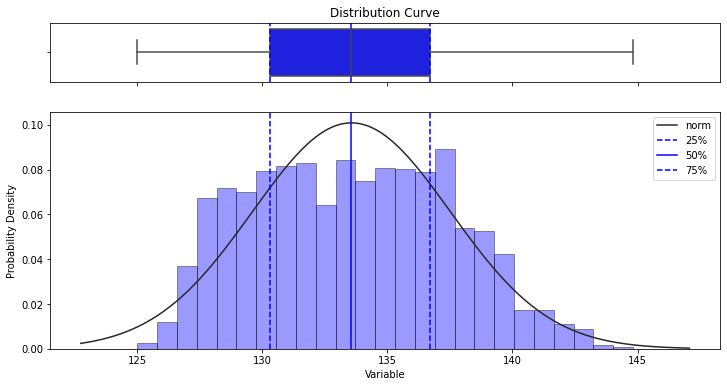

In [186]:
graphing_dist_box_plot(np.array(df),lw_lim=125,up_lim=145,limits=True,dist='norm',figsize=(12,6))

In [180]:
x = df['OO_HPG_CO_EST']
x = x[x>125]
x = x[x<145]
x = x.reset_index(drop=True)

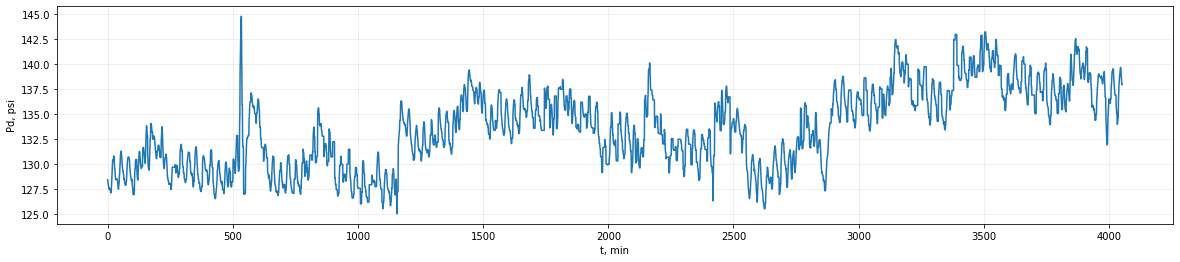

In [181]:
x.plot(figsize=(20,4))
plt.ylabel('Pd, psi'), plt.xlabel('t, min')
plt.grid(axis='both', alpha=0.25)
plt.show()

In [182]:
# Algoritmo comparar resultados, no admite NaN values.. !!
array_x = np.array(x.to_list())
results = comparar_distribuciones(x=array_x, familia='realall', ordenar='bic',verbose=False)

In [146]:
results.head()

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,gennorm,-11169.636886,22345.273771,22364.196149,3,"{'beta': 4.308792287957873, 'loc': 133.7678775..."
1,tukeylambda,-11221.316776,22448.633552,22467.555930,3,"{'lam': 0.3027535897731331, 'loc': 133.7924188..."
2,powernorm,-11254.739402,22515.478803,22534.401181,3,"{'c': 0.004729953987094505, 'loc': 125.9106475..."
3,genextreme,-11277.119798,22560.239595,22579.161973,3,"{'c': 0.2561659050921983, 'loc': 132.124100162..."
4,pearson3,-11309.135424,22624.270847,22643.193225,3,"{'skew': 0.4060725441039431, 'loc': 133.570425..."


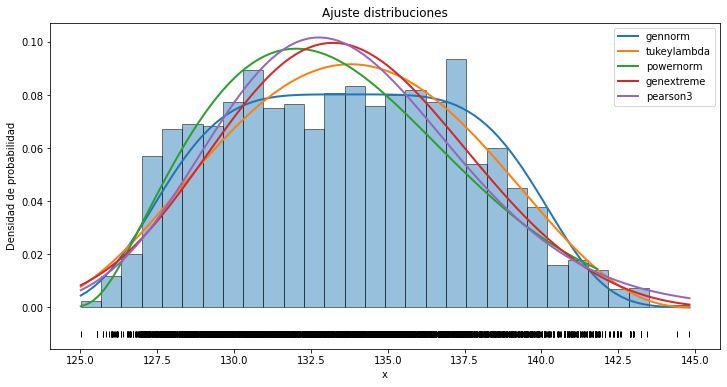

In [184]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plot_multiple_distribuciones(x=array_x,nombre_distribuciones=results['distribucion'][:5],ax=ax)
plt.show()

---------------------
Resultados del ajuste
---------------------
Distribución:   powernorm
Dominio:        [-inf, inf]
Parámetros:     {'c': 0.004729953987094505, 'loc': 125.91064752576895, 'scale': 0.42287546201379134}
Log likelihood: -11254.73940153145
AIC:            22515.4788030629
BIC:            22534.401181043933


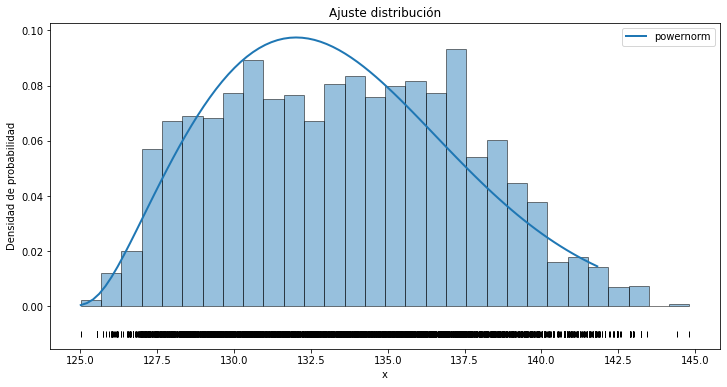

In [185]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plot_distribucion(x=array_x,nombre_distribucion='powernorm',ax=ax)
plt.show()

In [189]:
dist_name = 'powernorm'
para = {'c': 0.004729953987094505, 'loc': 125.91064752576895, 'scale': 0.42287546201379134}
dist_mode = getattr(stats,dist_name)

In [228]:
data_sim = dist_mode.rvs(c=0.004,loc=125.9,scale=0.42, size=100)

In [229]:
"""
Weibull module:
Weibull distribution:
    1) Probability density function
    2) Cumulative distribution function
    3) Mean
    4) Median
    5) Mode
    6) Variance - Standard deviation
    7) Skewness
    8) Gamma function (Lanczos approximation)
"""

import numpy as np
import cmath as cm

def weibProbDist(x, a, b):
    return (a / b) * (x / b) ** (a - 1) * np.exp(-(x / b) ** a)

def weibCumDist(x, a, b):
    return 1 - np.exp(-(x / b) ** a)

def weibMean(a, b):
    return b * gamma(1 + 1 / a)

def weibMedian(a, b):
    return b * np.log(2) ** (1 / a)

def weibMode(a, b):
    if a > 1:
        return b * ((a - 1) / a) ** (1 / a)
    else:
        return 0

def weibVar(a, b):
    return (b ** 2) * gamma(1 + 2 / a) - weibMean(a, b) ** 2


def weibSkew(a, b):
    ax_1 = gamma(1 + 3 / a) + 2 * (gamma(1 + 1 / a) ** 3)
    ax_2 = 3 * (gamma(1 + 2 / a) * gamma(1 + 1 / a))
    return (b ** 3) * (ax_1 - ax_2)

In [230]:
"""
Gamma function:

Lanczos approximation implementation.
Numerical Recipes in C (2nd ed. Cambridge University Press 1992)

"""
g = 5

p0 = float(1.000000000190015)
p1 = float(76.18009172947146)
p2 = float(-86.50532032941677)
p3 = float(24.01409824083091)
p4 = float(-1.231739572450155)
p5 = float(1.208650973866179e-3)
p6 = float(-5.395239384953e-6)

Pn_Coef = np.array([p0, p1, p2, p3, p4, p5, p6])


def gamma(z):
    z = complex(z)
    if z.real < 0.5:
        #Recursion method:
        return cm.pi / (cm.sin(cm.pi * z) * gamma(1 - z))
    else:
        ax_1 = cm.sqrt(cm.pi * 2) / z
        ax2_sum = Pn_Coef[0]
        for i in range(1, g + 2):
            ax2_sum += Pn_Coef[i] / (z + i)
        t = z + g + 0.5
        ax_3 = (t ** (z + 0.5)) * cm.exp(-t)
        return ((ax_1 * ax2_sum) * ax_3).real

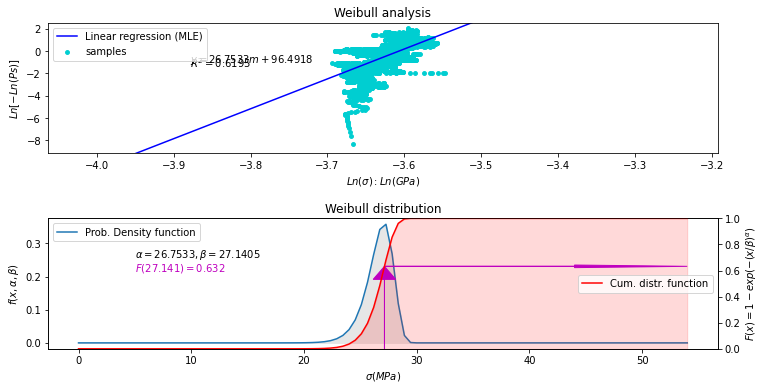

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
# from weibull import *
import csv

#inputs:
L, r = float(40), float(4)
path = '../Data_Test.csv'
pathReport = '../WeibullReport.csv'


def FailureProb(n, N):
    if(N < 100):
        #Bernard's approximation
        return (n - 0.3) / (N + 0.4)
    else:
        #Mean Ranks
        return n / (N + 1)


def MaxStress(F, L, r):
    # Maximum Stress (cylinder 3 points)
    return (F * L) / (math.pi * r ** 3)

aSamples = array_x

aFailureProb = aSamples.copy()
aFailureStress = aSamples.copy()

for i in range(len(aFailureProb)):
    aFailureProb[i] = FailureProb((i + 1), float(len(aSamples) + 1))
    aFailureStress[i] = MaxStress(aSamples[i], L, r)

MeanForces = np.mean(aSamples)
MeanStress = np.mean(aFailureStress)

#Survival probability = 1 - Failure Probability
aSurvivalProb = 1 - aFailureProb

#Linear regression: parameters (m, b)
aLnPs = np.log(- np.log(aSurvivalProb))
aLnFS = np.log(aFailureStress / 1000)

slope, intercept, r_square, s, std_error = stats.linregress(aLnFS, aLnPs)
regressLine = slope * aLnPs + intercept

m = slope
b = intercept

#Characteristic life : Stress
Stress = np.exp(- (intercept / slope)) * 1000
Pr_Stress = weibCumDist(Stress, slope, Stress)

# export results to .csv
Results = [
            ['Parameters', 'Value', 'Units'],
            ['shape (alpha)', slope],
            ['scale (beta)', Stress, 'MPa'],
            ['Mean', weibMean(slope, Stress), 'MPa'],
            ['Median', weibMean(slope, Stress), 'MPa'],
            ['Mode', weibMode(slope, Stress), 'MPa'],
            ['Variance', weibVar(slope, Stress), 'MPa^2'],
            ['Standard Deviation', np.sqrt(weibVar(slope, Stress)), 'MPa'],
            ['Skewness', weibSkew(slope, Stress)]
          ]

# with open(pathReport, 'wb') as f:
#     writer = csv.writer(f)
#     writer.writerows(Results)

#Plots:
fig = plt.figure('Weibull', figsize=(12,6))
ax1 = fig.add_subplot(211)
scatt = ax1.scatter(aLnFS, aLnPs, label='samples', c='DarkTurquoise', s=15)
regres = ax1.plot(aLnPs, regressLine, 'b-', label='Linear regression (MLE)')
ax1.set_ylabel('$Ln[-Ln(Ps)]$')
ax1.set_xlabel('$Ln(\sigma) : Ln(GPa)$')
ax1.set_title('Weibull analysis')
ax1.set_ylim(min(aLnPs) * 1.1, max(aLnPs) * 1.25)
ax1.set_xlim(min(aLnFS) * 1.1, max(aLnFS) * 0.9)
ax1.legend(loc=2, prop={'size': 10})
ax1.text(min(aLnFS) * 1.05, -1, r'$y=%.4f m + %.4f$' % (m, b))
ax1.text(min(aLnFS) * 1.05, -1.5, r'$R^2=%.4f$' % r_square)

x = np.linspace(0, round(Stress * 2, 0), 100)
ax2 = fig.add_subplot(212)
ax2.set_title('Weibull distribution')
ax2.plot(x, weibProbDist(x, slope, Stress), label='Prob. Density function')
ax2.fill_between(x, weibProbDist(x, slope, Stress), 0, color='0.90')
ax2.set_ylabel(r'$f(x, {\alpha}, {\beta})$')
ax2.set_xlabel(r'${\sigma} (MPa)$')
ax3 = ax2.twinx()
ax3.plot(x, weibCumDist(x, slope, Stress), 'r', label='Cum. distr. function')
ax3.fill_between(x, weibCumDist(x, slope, Stress), alpha=0.15, color='r')
ax3.set_ylim(0, 1)
ax3.set_ylabel(r'$F(x) = 1-exp(-(x/{\beta})^{\alpha})$')
ax3.legend(loc=7, prop={'size': 10})
ax2.legend(loc=2, prop={'size': 10})

#Text:
ax3.text(5, 0.7, r'${\alpha} = %.4f, {\beta} = %.4f$' % (m, Stress))
ax3.text(5, 0.6, r'$F(%s) = %s$' % (round(Stress, 3), round(Pr_Stress, 3)),
color='m')

#Arrows:
ax3.arrow(Stress, 0, 0, Pr_Stress - 0.1, head_width=2, head_length=0.1,
ec='m', fc='m')
ax3.arrow(Stress, Pr_Stress, round(Stress * 2, 0) - Stress - 10, 0,
head_width=0.02, head_length=10, ec='m', fc='m')

fig.subplots_adjust(hspace=0.5)
plt.show()

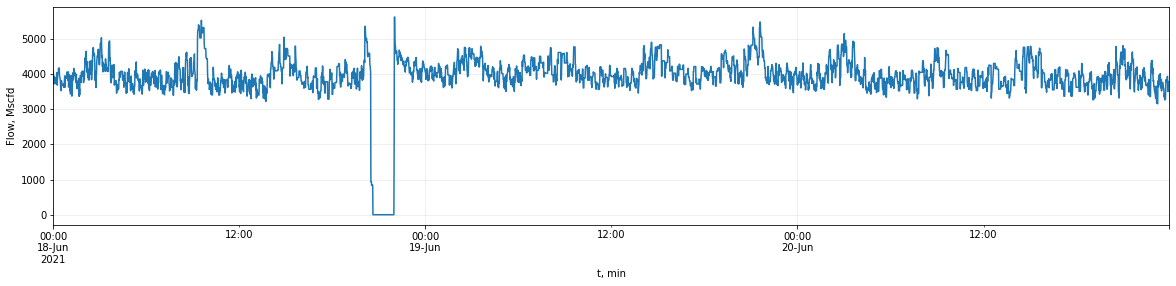

In [52]:
df['OO_HPG_CO_INST'].plot(figsize=(20,4))
plt.ylabel('Flow, Mscfd'), plt.xlabel('t, min')
plt.grid(axis='both', alpha=0.25)
plt.show()

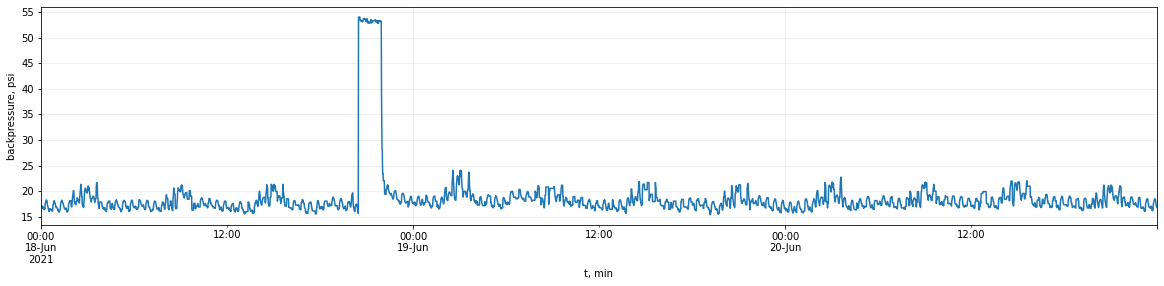

In [53]:
df['OO_LPG_EG_EST'].plot(figsize=(20,4))
plt.ylabel('backpressure, psi'), plt.xlabel('t, min')
plt.grid(axis='both', alpha=0.25)
plt.show()

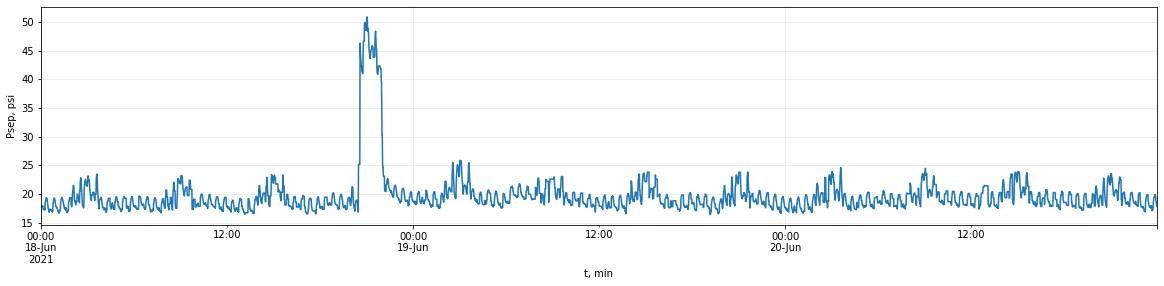

In [54]:
df['OO_LPG_BP_EST'].plot(figsize=(20,4))
plt.ylabel('Psep, psi'), plt.xlabel('t, min')
plt.grid(axis='both', alpha=0.25)
plt.show()

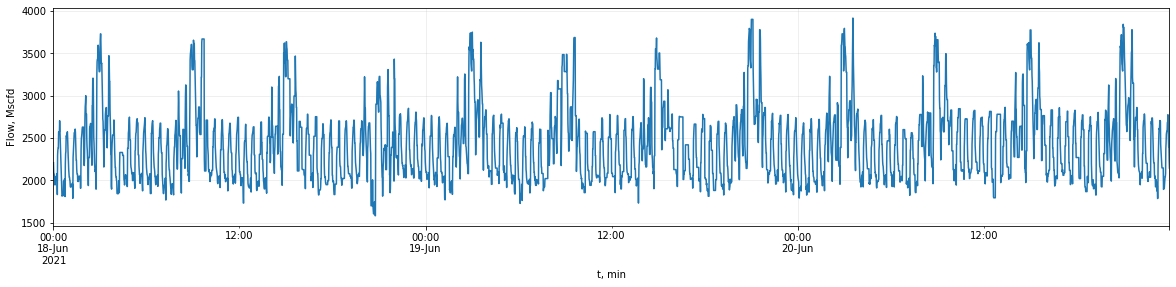

In [55]:
df['OO_LPG_BP_INST'].plot(figsize=(20,4))
plt.ylabel('Flow, Mscfd'), plt.xlabel('t, min')
plt.grid(axis='both', alpha=0.25)
plt.show()

In [60]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

df['time'] = df.index
# data
df_long=pd.melt(df, id_vars=['time'], value_vars=['OO_HPG_CO_EST','OO_LPG_EG_EST','OO_LPG_BP_EST','OO_LPG_BP_DIF'])
# plotly 
fig = px.line(df_long, x='time', y='value', color='variable')

# Show plot 
fig.show()

In [62]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

df['time'] = df.index
# data
df_long=pd.melt(df, id_vars=['time'], value_vars=['OO_HPG_CO_EST','OO_HPG_GL_EST'])
# plotly 
fig = px.line(df_long, x='time', y='value', color='variable')
# Show plot 
fig.show()